In [1]:
import pyspark

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType

#Define name, type for each column in the spark dataframe

schema = StructType([
    StructField("user", IntegerType(), True),
    StructField("movie", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True)])

df_ratings = spark.read.csv('data/u.data', sep='\t', header=False, schema=schema)

In [4]:
df_ratings.show(5)

+----+-----+------+---------+
|user|movie|rating|timestamp|
+----+-----+------+---------+
| 196|  242|     3|881250949|
| 186|  302|     3|891717742|
|  22|  377|     1|878887116|
| 244|   51|     2|880606923|
| 166|  346|     1|886397596|
+----+-----+------+---------+
only showing top 5 rows



<h3> Get some statistics about the data </h3>

In [5]:
print('Number of unique users: {}'.format(df_ratings.select('user').distinct().count()))
print('Number of unique movies: {}'.format(df_ratings.select('movie').distinct().count()))
print('Number of rating: {}'.format(df_ratings.count()))

Number of unique users: 943
Number of unique movies: 1682
Number of rating: 100000


In [6]:
# The density of the matrix is 
100000/(943*1682)

0.06304669364224531

<h3> Splitting the data into train and test set</h3>

In [7]:
train, test = df_ratings.randomSplit([0.8, 0.2])

<h3> Looking at the distribution of movie ratings per user and vice versa</h3>

Max Ratings: 598
Min Ratings: 11


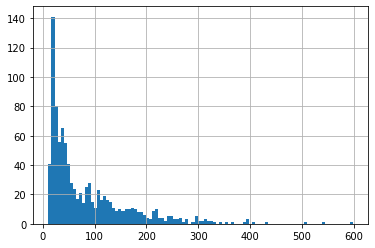

In [8]:
# Find out how many movie ratings each user has in this data set

user_count = train.groupBy('user').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 461
Min Ratings: 1


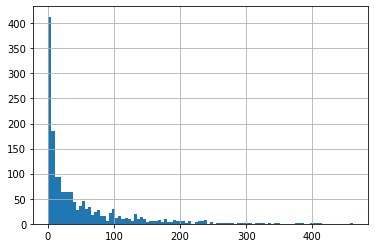

In [9]:
# How many user ratings each movie has

movie_count = train.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)


<h3> Training the ALS model </h3>

In [20]:
from pyspark.ml.recommendation import ALS

als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10)

# rank is the number of latent factors we are choosing

recommender = als_model.fit(train)

In [21]:
predictions = recommender.transform(test)

In [22]:
predictions.describe().show()

+-------+------------------+------------------+------------------+-------------------+----------+
|summary|              user|             movie|            rating|          timestamp|prediction|
+-------+------------------+------------------+------------------+-------------------+----------+
|  count|             20082|             20082|             20082|              20082|     20082|
|   mean|462.22428045015437|  425.601782690967| 3.534956677621751|8.835202599002589E8|       NaN|
| stddev| 267.3245093499304|329.43062116242817|1.1271877766662577| 5336286.9638603665|       NaN|
|    min|                 1|                 1|                 1|          874724754|0.19464321|
|    max|               943|              1678|                 5|          893286638|       NaN|
+-------+------------------+------------------+------------------+-------------------+----------+



Looks like our data contains missing values

We'll fill the missing values with the mean rating from the train data set

In [23]:
predictions_df = predictions.toPandas()
train_df = train.toPandas()


In [24]:
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [25]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [26]:
predictions_df.head()

,user,movie,rating,timestamp,prediction,squared_error
0,633,148,1,875326138,3.068229,4.277570
1,406,148,3,879540276,2.724735,0.075771
2,606,148,3,878150506,3.443842,0.196996
3,222,148,2,881061164,2.932135,0.868876
4,416,148,5,893212730,3.761259,1.534478


In [27]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.9235233270568699

In [33]:
# Get predictions vs true ratings
rating = 1
predictions_df['prediction'][predictions_df['rating'] == rating]

0        3.068229
13       1.324625
20       2.589666
150      1.274494
157      1.593853
           ...   
19994    0.843068
20042    3.229910
20053    2.631510
20056    2.308659
20059    1.664041
Name: prediction, Length: 1215, dtype: float32

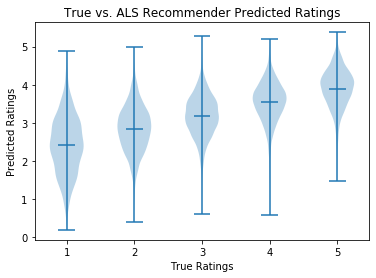

In [35]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [38]:
# Generate top 10 movie recommendations for each user
userRecs = recommender.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = recommender.recommendForAllItems(10)


In [87]:
userRecs_df = userRecs.toPandas()
movieRecs_df = movieRecs.toPandas()

Here I'll write a quick python function to return user recommendations by user id

In [82]:
def get_movie_recommendations(user_id):
    return userRecs_df.loc[user_id].recommendations

In [84]:
get_movie_recommendations(471)

[Row(movie=1367, rating=4.554364204406738),
 Row(movie=1104, rating=4.431693077087402),
 Row(movie=512, rating=4.368035793304443),
 Row(movie=1463, rating=4.363348960876465),
 Row(movie=1536, rating=4.302144527435303),
 Row(movie=179, rating=4.287587642669678),
 Row(movie=169, rating=4.287128925323486),
 Row(movie=1512, rating=4.265692710876465),
 Row(movie=647, rating=4.246166706085205),
 Row(movie=119, rating=4.2333502769470215)]

In [85]:
def get_user_recommendations(movie_id):
    return movieRecs_df.loc[movie_id].recommendations

In [88]:
get_user_recommendations(1367)

[Row(user=366, rating=6.583684921264648),
 Row(user=50, rating=6.097272872924805),
 Row(user=628, rating=5.690324783325195),
 Row(user=859, rating=5.690299034118652),
 Row(user=672, rating=5.604427337646484),
 Row(user=427, rating=5.577846527099609),
 Row(user=4, rating=5.530691623687744),
 Row(user=270, rating=5.519705772399902),
 Row(user=928, rating=5.249945640563965),
 Row(user=770, rating=5.228704452514648)]

<h3> Potential use cases </h3>

After building the recommenders, I could now use the get_movie_recommendations function to suggest movies to watch for existing users. 

The get_user_recommendations function can be used to target users for advertising and products related to the movie, such as sequels or merchandise.